In [1060]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Project: Using PCA to Predict the Price of Common Grocery Items
Motivation: Recently, we have been hearing a lot about recalls for grocery items, while also constantly hearing about rising prices due to inflation. It is known that recalls can cost millions every year. My thinking is that if an item is carrying salmonella or some other pathogen, there will be less items on shelves as they get pulled, and the price may go up. On the other hand, the presense of an outbreak might decrease demand if everyone is informed of the outbreak, which would decrease the price. Either way, I want to see if this, along with inflation and gas prices can be used to predict the price of basic groceries.

## Section 1: Exploration

### Grocery prices data (dataset 1)
I am going to be looking at data from the [US Bureau of Labor Statistics](https://www.bls.gov/charts/consumer-price-index/consumer-price-index-average-price-data.htm), as a part of the [consumer price index summary](https://www.bls.gov/news.release/cpi.nr0.htm).

In [1061]:
grocs = pd.read_csv("groceries_data.csv", header=1)

# I don't really care about the electricity prices for this project, but I will set it aside in its own DF for now
groceries_data = grocs.drop(["Utility (piped) gas per therm", "Electricity per KWH"], axis=1)
electric_data = grocs[["Gasoline, unleaded regular, per gallon", "Utility (piped) gas per therm"]]

# Renaming columns for clarity / brevity
new_cols = {"Month": "Date", "Bananas, per lb.": "Bananas", "Oranges, Navel, per lb.": "Oranges", "Bread, white, pan, per lb.": "Bread",
            "Tomatoes, field grown, per lb.": "Tomatoes", "Chicken, fresh, whole, per lb.": "Chicken", "Eggs, grade A, large, per doz.": "Eggs",
            "Ground chuck, 100% beef, per lb.": "Beef", "Milk, fresh, whole, fortified, per gal.": "Milk", "Gasoline, unleaded regular, per gallon": "Gas"}

groceries_data = groceries_data.rename(new_cols, axis=1)
groceries_data.head()

,Date,Bananas,Oranges,Bread,Tomatoes,Chicken,Eggs,Gas,Beef,Milk
0,Aug-04,0.507,NaN,0.996,1.312,1.092,1.277,1.898,2.537,3.297
1,Sep-04,0.488,1.142,0.985,1.321,1.078,1.145,1.891,2.512,3.149
2,Oct-04,0.485,NaN,0.972,1.715,1.078,1.089,2.029,2.484,3.161
3,Nov-04,0.469,1.080,0.976,2.337,1.039,1.085,2.010,2.461,3.219
4,Dec-04,0.474,0.865,0.970,2.467,1.030,1.199,1.882,2.465,3.233


Some more cleaning for later usage and plotting:

In [1062]:
groceries_data["Month"] = groceries_data["Date"].str.split("-").str[0]
groceries_data["Year"] = "20" + groceries_data["Date"].str.split("-").str[1]

# Map Month to numeric
groceries_data["Year"] = groceries_data["Year"].astype(int)
months_mapping = {"Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6, "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12}
groceries_data["Month"] = [months_mapping[month] for month in groceries_data["Month"]]

# Turn date into an actual DateTime
groceries_data["Date"] = pd.to_datetime(groceries_data[['Year', 'Month']].assign(Day=1))
groceries_data = groceries_data.drop(["Month", "Year"], axis=1)
groceries_data = groceries_data.set_index("Date")

groceries_data.head()

,Bananas,Oranges,Bread,Tomatoes,Chicken,Eggs,Gas,Beef,Milk
Date,,,,,,,,,
2004-08-01,0.507,NaN,0.996,1.312,1.092,1.277,1.898,2.537,3.297
2004-09-01,0.488,1.142,0.985,1.321,1.078,1.145,1.891,2.512,3.149
2004-10-01,0.485,NaN,0.972,1.715,1.078,1.089,2.029,2.484,3.161
2004-11-01,0.469,1.080,0.976,2.337,1.039,1.085,2.010,2.461,3.219
2004-12-01,0.474,0.865,0.970,2.467,1.030,1.199,1.882,2.465,3.233


### CDC foodborne illnesses (dataset 2)
I am going to use data from the CDC's NORS [(national outbreak reporting system)](https://www.cdc.gov/nors/about/index.html) to look at [foodborne illnesses](https://www.cdc.gov/ncezid/dfwed/BEAM-dashboard.html). I would like to know if and how foodborne illnesses affect grocery prices.

In [1063]:
cdc_outbreaks = pd.read_csv("BEAM_data.csv")
display(cdc_outbreaks.describe(), cdc_outbreaks.head())

,Year,Month,Number of isolates,Outbreak associated isolates,New multistate outbreaks,New multistate outbreaks - US,% Isolates with clinically important antimicrobial resistance,Number of sequenced isolates analyzed by NARMS
count,118174.000000,118174.000000,118174.000000,13441.000000,6094.000000,690.000000,1278.000000,6719.000000
mean,2020.856229,6.642849,2.827077,2.095826,1.078766,1.020290,1.852113,2.088555
std,1.987209,3.188426,6.026918,4.327863,0.321604,0.141092,3.760764,4.110565
min,2018.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2019.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,2021.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,2023.000000,9.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000
max,2024.000000,12.000000,236.000000,210.000000,5.000000,2.000000,109.000000,206.000000


,Year,Month,State,Source,Pathogen,Serotype/Species,Number of isolates,Outbreak associated isolates,New multistate outbreaks,New multistate outbreaks - US,% Isolates with clinically important antimicrobial resistance,Number of sequenced isolates analyzed by NARMS
0,2024,1,AK,Stool,Campylobacter,jejuni,1,NaN,NaN,NaN,NaN,NaN
1,2024,1,AL,Stool,Campylobacter,coli,1,NaN,NaN,NaN,NaN,NaN
2,2024,1,AL,Stool,Campylobacter,jejuni,2,NaN,NaN,NaN,NaN,NaN
3,2024,1,AR,Stool,Campylobacter,jejuni,1,NaN,NaN,NaN,NaN,NaN
4,2024,1,CA,Stool,Campylobacter,jejuni,1,NaN,NaN,NaN,NaN,NaN


It appears that we are only working with 5 pathogens (Campylobacter, STEC, Salmonella, Shigella, Vibrio), but 831 unique species. I will include a reference here for what these columns all mean: </br>

3. **Source**: Describes the origin of the sample, such as stool, water, or food products. The source helps to trace infection pathways and identify contamination sources, which is critical for outbreak control and prevention.

4. **Pathogen**: Specifies the microorganism (e.g., *Campylobacter*, *Salmonella*) responsible for the infection. Identifying the pathogen is essential for diagnosing cases, guiding treatment, and determining appropriate public health responses.

5. **Serotype/Species**: Provides a more precise identification of the pathogen, including species or serotype (e.g., *jejuni* for *Campylobacter*). Knowing the serotype or species helps in understanding the pathogen's virulence and its potential resistance profile.

6. **Number of Isolates**: Counts the samples (isolates) tested that match the pathogen and serotype/species. This measure indicates the prevalence of the pathogen and its strains, helping gauge the outbreak's scale or persistence.

7. **Outbreak Associated Isolates**: Identifies isolates linked directly to an outbreak. Tracking these helps assess the outbreak's reach and containment status and differentiate sporadic cases from those in a larger event.

8. **New Multistate Outbreaks**: Indicates whether an outbreak spans multiple states, with this field often associated with large-scale contamination or widespread pathogen exposure.

9. **New Multistate Outbreaks - US**: Similar to the previous column but specifically points out multistate outbreaks within the U.S., emphasizing domestic spread and the potential need for national-level public health interventions.

10. **% Isolates with Clinically Important Antimicrobial Resistance**: Shows the percentage of pathogen isolates exhibiting resistance to important antimicrobials, crucial information for assessing treatment challenges and the need for antimicrobial stewardship.

11. **Number of Sequenced Isolates Analyzed by NARMS**: Counts the isolates sequenced and analyzed by the National Antimicrobial Resistance Monitoring System (NARMS). Sequencing data helps track resistance patterns and understand pathogen evolution, assisting in controlling the spread of resistant strains. 

I think, at least initially, I only want to look at the "Number of Isolates" column because it appears to have the least NA values, and it is the most clear metric of an outbreak.

In [1064]:
# Combine Year and Month into a datetime column
cdc_outbreaks['Date'] = pd.to_datetime(cdc_outbreaks[['Year', 'Month']].assign(Day=1))

### Looking at CDC foodborne illnesses data
I want to see what unique values I have here, because the averages of these values doesn't mean much to me.

In [1065]:
year_range = (min(cdc_outbreaks["Year"]), max(cdc_outbreaks["Year"]))
all_pathogens = np.unique(cdc_outbreaks["Pathogen"])
all_species = np.unique(cdc_outbreaks["Serotype/Species"])

display(year_range, all_pathogens, len(all_species))

(2018, 2024)

array(['Campylobacter', 'STEC', 'Salmonella', 'Shigella', 'Vibrio'],
      dtype=object)

831

### Inflation rates (datset 3)
I am next looking at the consumer Index report for [inflation.](https://data.bls.gov/pdq/SurveyOutputServlet)

In [1066]:
# Looking at inflation rates
inflation = pd.read_csv("SeriesReport-20241114114945_0d31fe.csv", skiprows=11)

inflation_timeframe = inflation[inflation["Year"].between(2018, 2024)].drop(["HALF1", "HALF2"], axis=1)
inflation_melted = inflation_timeframe.melt(id_vars="Year", var_name="Month", value_name="Inflation rate")


month_mapping = {
    "Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6,
    "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12
}

# Fix dates again
inflation_melted['Month'] = inflation_melted['Month'].map(month_mapping)
inflation_melted['Date'] = pd.to_datetime(inflation_melted[['Year', 'Month']].assign(Day=1))
inflation_melted.set_index('Date', inplace=True)
inflation_melted

,Year,Month,Inflation rate
Date,,,
2018-01-01,2018,1,1.8
2019-01-01,2019,1,2.2
2020-01-01,2020,1,2.3
2021-01-01,2021,1,1.4
2022-01-01,2022,1,6.0
...,...,...,...
2020-12-01,2020,12,1.6
2021-12-01,2021,12,5.5
2022-12-01,2022,12,5.7


### General trends
It looks like there is a postive overall trend, with bananas being very stable, and eggs, beef, and milk appearing to have more unpredictable fluctuations. We can probably assume that for seasonal produce, these fluctuations are partially due to seasonal changes (oranges and tomatoes seem to fluctuate similarly, without overall increases). </br>
I will also create some summary statistics for the data.

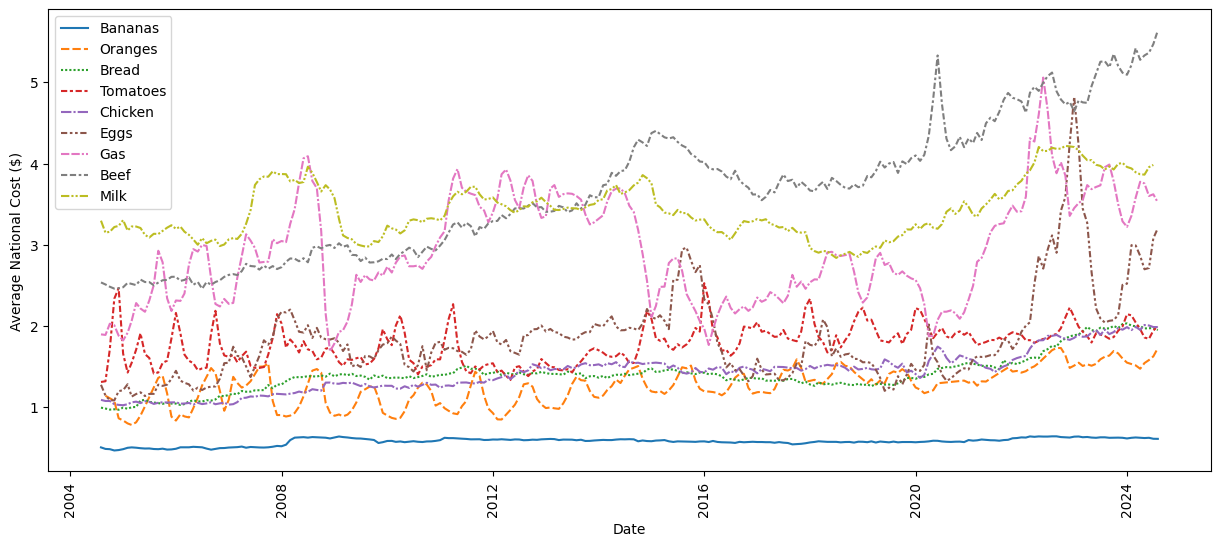

In [1067]:
plt.figure(figsize=(15,6))
sns.lineplot(data=groceries_data)
plt.xlabel("Date")
plt.ylabel("Average National Cost ($)")
plt.xticks(rotation=90)
plt.show()

In [1068]:
groceries_data.describe()

,Bananas,Oranges,Bread,Tomatoes,Chicken,Eggs,Gas,Beef,Milk
count,241.000000,225.000000,241.000000,238.000000,240.000000,241.000000,241.000000,241.000000,240.000000
mean,0.579556,1.252796,1.405307,1.776534,1.428383,1.844440,2.921660,3.654842,3.427100
std,0.043154,0.229195,0.229931,0.229872,0.249099,0.563653,0.653061,0.826214,0.343088
min,0.469000,0.783000,0.970000,1.312000,1.026000,1.085000,1.689000,2.459000,2.839000
25%,0.570000,1.080000,1.295000,1.591000,1.260500,1.481000,2.351000,2.890000,3.161000
50%,0.583000,1.270000,1.388000,1.798500,1.463000,1.755000,2.835000,3.668000,3.374000
75%,0.608000,1.438000,1.457000,1.911000,1.530750,1.998000,3.482000,4.217000,3.669500
max,0.643000,1.730000,2.033000,2.528000,2.013000,4.823000,5.058000,5.638000,4.218000


### Initial impressions of grocery prices dataset
Average national prices for some goods varies with the season, while others may vary for less obvious reasons. The first thing that comes to mind with animal products is foodborne illnesses. I also suspect that gas prices may affect food prices, since many items need to be transported far distances.

Since the data from the CDC datset only ranges from 2018 to 2024, I want to restrict my groceries data in the same way.

80

118174

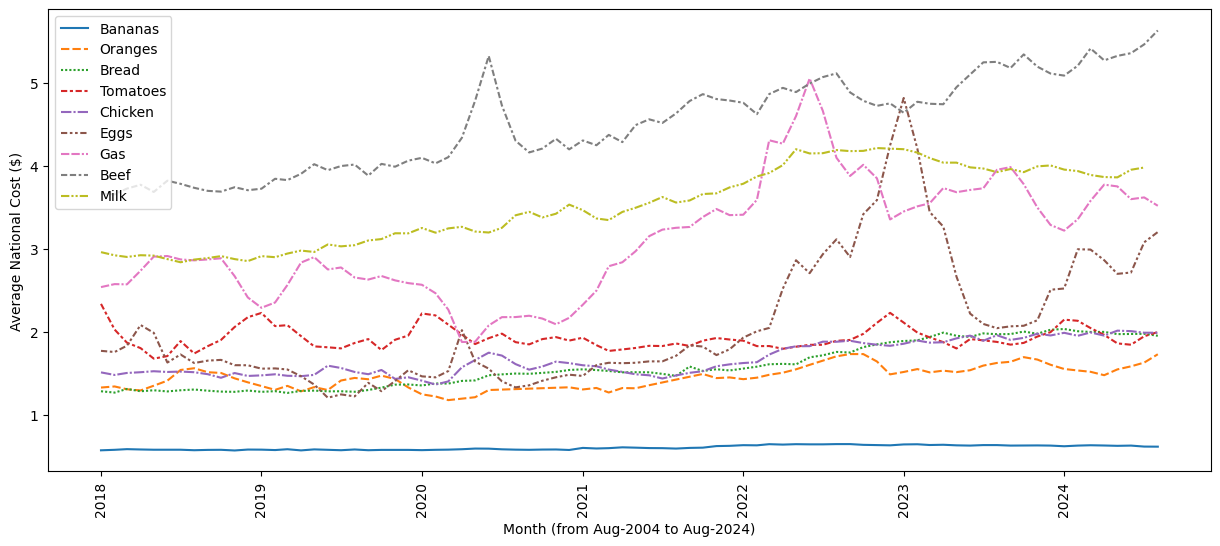

In [1069]:
# Restrict the groceries data to all of 2018 to all of 2024
start_date = "2018-01-01"
end_date = "2024-12-31"
groceries_data = groceries_data.loc[start_date:end_date]

display(len(groceries_data), len(cdc_outbreaks))

plt.figure(figsize=(15,6))
sns.lineplot(groceries_data)
plt.xlabel("Month (from Aug-2004 to Aug-2024)")
plt.xticks(rotation=90)
plt.ylabel("Average National Cost ($)")
plt.show()

In [1070]:
groceries_data.head()

,Bananas,Oranges,Bread,Tomatoes,Chicken,Eggs,Gas,Beef,Milk
Date,,,,,,,,,
2018-01-01,0.568,1.326,1.281,2.336,1.509,1.769,2.539,3.668,2.961
2018-02-01,0.574,1.339,1.265,2.026,1.478,1.755,2.575,3.659,2.923
2018-03-01,0.582,1.305,1.309,1.868,1.502,1.831,2.572,3.728,2.903
2018-04-01,0.578,1.291,1.281,1.802,1.511,2.081,2.737,3.775,2.924
2018-05-01,0.575,1.348,1.293,1.675,1.523,1.987,2.907,3.688,2.919


We only have 80 records from 2018-2024 (7 years * 12 months $\approx$ 80), but we have 118,174 records from the cdc disease outbreak dataset. Let's investigate the cdc dataset more to see if it makes sense to do any more filtering. I will first fix the date like I did above to make it a real datetime.

,Date,Pathogen,Number of isolates
0,2018-01-01,Campylobacter,276
1,2018-01-01,Salmonella,2531
2,2018-01-01,Vibrio,3
3,2018-02-01,Campylobacter,234
4,2018-02-01,Salmonella,2344
...,...,...,...
245,2024-08-01,Salmonella,6305
247,2024-08-01,Vibrio,72
249,2024-09-01,Salmonella,2648
248,2024-09-01,Campylobacter,157


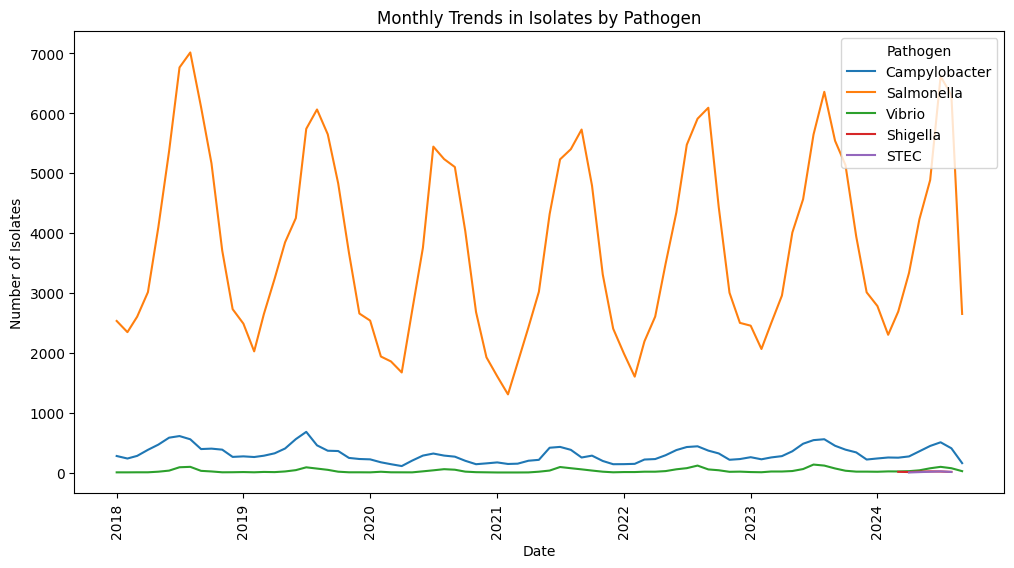

In [1071]:
# Group data for plotting
monthly_trends = cdc_outbreaks.groupby(['Date', 'Pathogen'])['Number of isolates'].sum().reset_index()

# Sort by Date to ensure order
monthly_trends.sort_values(by='Date', inplace=True)
display(monthly_trends)

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_trends, x='Date', y='Number of isolates', hue='Pathogen')

# Customize the plot
plt.title('Monthly Trends in Isolates by Pathogen')
plt.xlabel('Date')
plt.ylabel('Number of Isolates')
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.legend(title='Pathogen')
plt.show()

It looks like we have extreme monthly trends for salmonella and more slight trends in Campylobacter and Vibrio that have peaks corresponding to those of salmonella. Shigella and STEC don't have records of isolates until 2024. Based on this, we only need to look at salmonella, campylobacter, and vibrio. This eliminates a few rows, but we still have 118,135 records.

In [1072]:
cdc_outbreaks = cdc_outbreaks[cdc_outbreaks["Pathogen"].isin(['Campylobacter', 'Salmonella', 'Vibrio'])]
len(cdc_outbreaks)

118135

I want to look at inflation and grocery prices on the same axes to verify my intuition that they vary together.

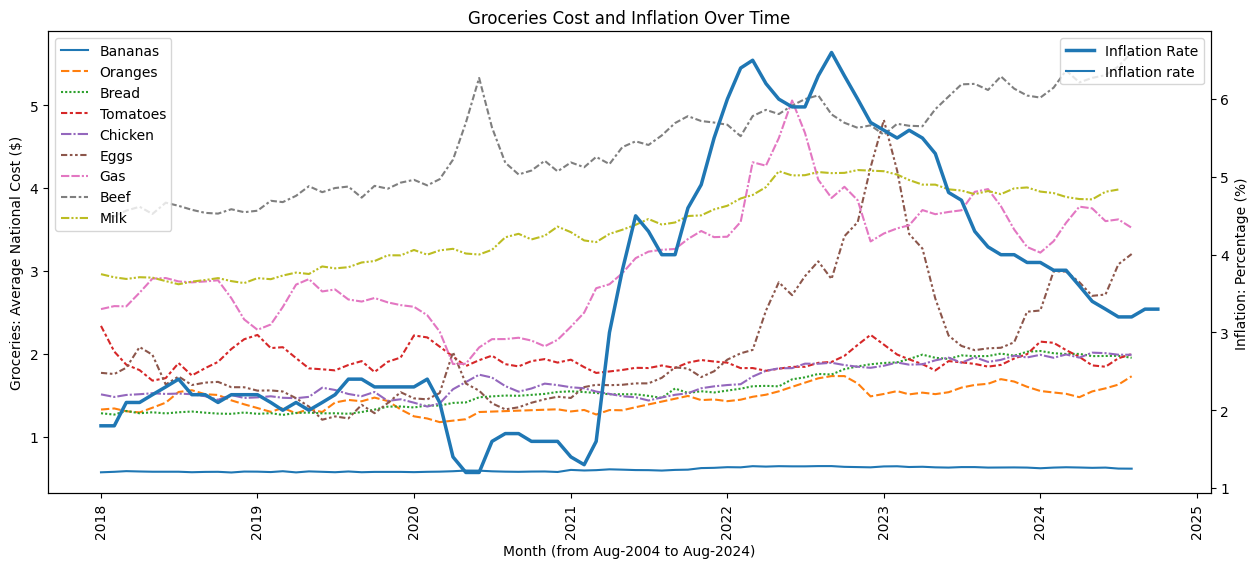

In [1073]:
fig, ax1 = plt.subplots(figsize=(15, 6))

sns.lineplot(data=groceries_data, ax=ax1)
ax1.set_xlabel("Month (from Aug-2004 to Aug-2024)")
ax1.set_ylabel("Groceries: Average National Cost ($)")
ax1.tick_params(axis='y')
plt.xticks(rotation=90)

ax2 = ax1.twinx()
sns.lineplot(
    data=inflation_melted.drop(["Year", "Month"], axis=1).dropna(),
    ax=ax2,
    color='black',
    linewidth=2.5,  
    linestyle='solid', 
    label='Inflation Rate'
)
ax2.set_ylabel("Inflation: Percentage (%)")
ax2.tick_params(axis='y')

plt.title("Groceries Cost and Inflation Over Time")
plt.show()


We can see that gas and eggs vary the most clearly with inflation with those peaks in 2022-2023. Other items may vary with inflation in more subtle ways.

## Section 2: Inference

Questions to be answered: </br>
- How well can gas price, inflation rate, and outbreak count predict the price of any of the given grocery items? </br>
- After evaluating how well the model predicts prices for each item, why are some items easier to predict than others?

#### Evaluating linear associations
I want to see if any of the specific pathogens are associated with a change in price in any of the grocery items (linearly), so I will pivot the pathogen data and make a correlation heatmap.

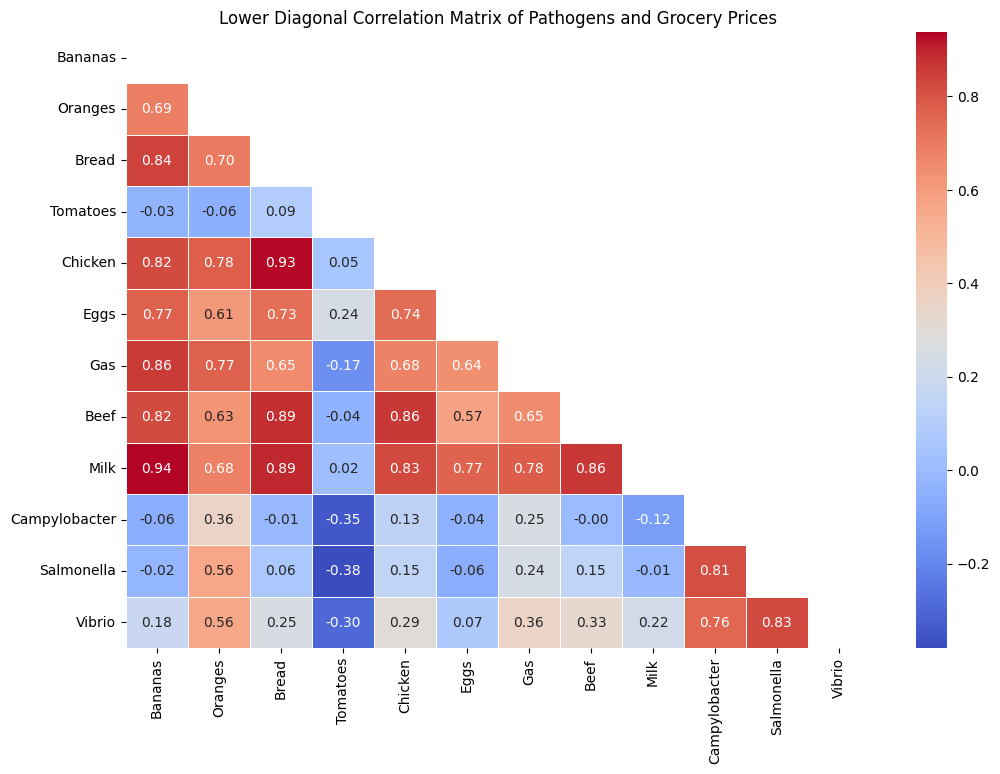

In [1074]:
# Aggregating CDC outbreak data
cdc_outbreaks_agg = (
    cdc_outbreaks.groupby(['Date', 'Pathogen'], as_index=False)
    .agg({'Number of isolates': 'sum'})
)

# Pivot CDC data so each pathogen is a column
cdc_pivot = cdc_outbreaks_agg.pivot_table(
    index=['Date'], 
    columns='Pathogen', 
    values='Number of isolates', 
    aggfunc='sum'
).reset_index()

# Merging with groceries data
merged_data = pd.merge(
    groceries_data, 
    cdc_pivot, 
    on=['Date'], 
    how='inner'
)

# Selecting only numeric columns for correlation
numeric_cols = merged_data.select_dtypes(include='number')

correlation_matrix = numeric_cols.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix, 
    mask=mask,  # Apply the mask to the upper triangle
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f", 
    linewidths=.5
)
plt.title("Lower Diagonal Correlation Matrix of Pathogens and Grocery Prices")
plt.show()

The most significant linear relationships between any of the 3 pathogens and the 8 grocery items is between oranges and salmonella / vibrio. There is a somewhat weak linear relationship between beef & vibrio and chicken & vibrio (about +0.3 for each), and a strangely negative correlation between tomatoes and all 3 pathogens (about -0.35 for each pathogen). It may not make sense to use a purely linear model to predict prices based on these pathogens.

In [1075]:
cdc_outbreaks = cdc_outbreaks.set_index("Date").drop(["Year", "Month"], axis=1)

Visualizing grocery prices & inflation relationships.

/Users/madikloberdanz/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


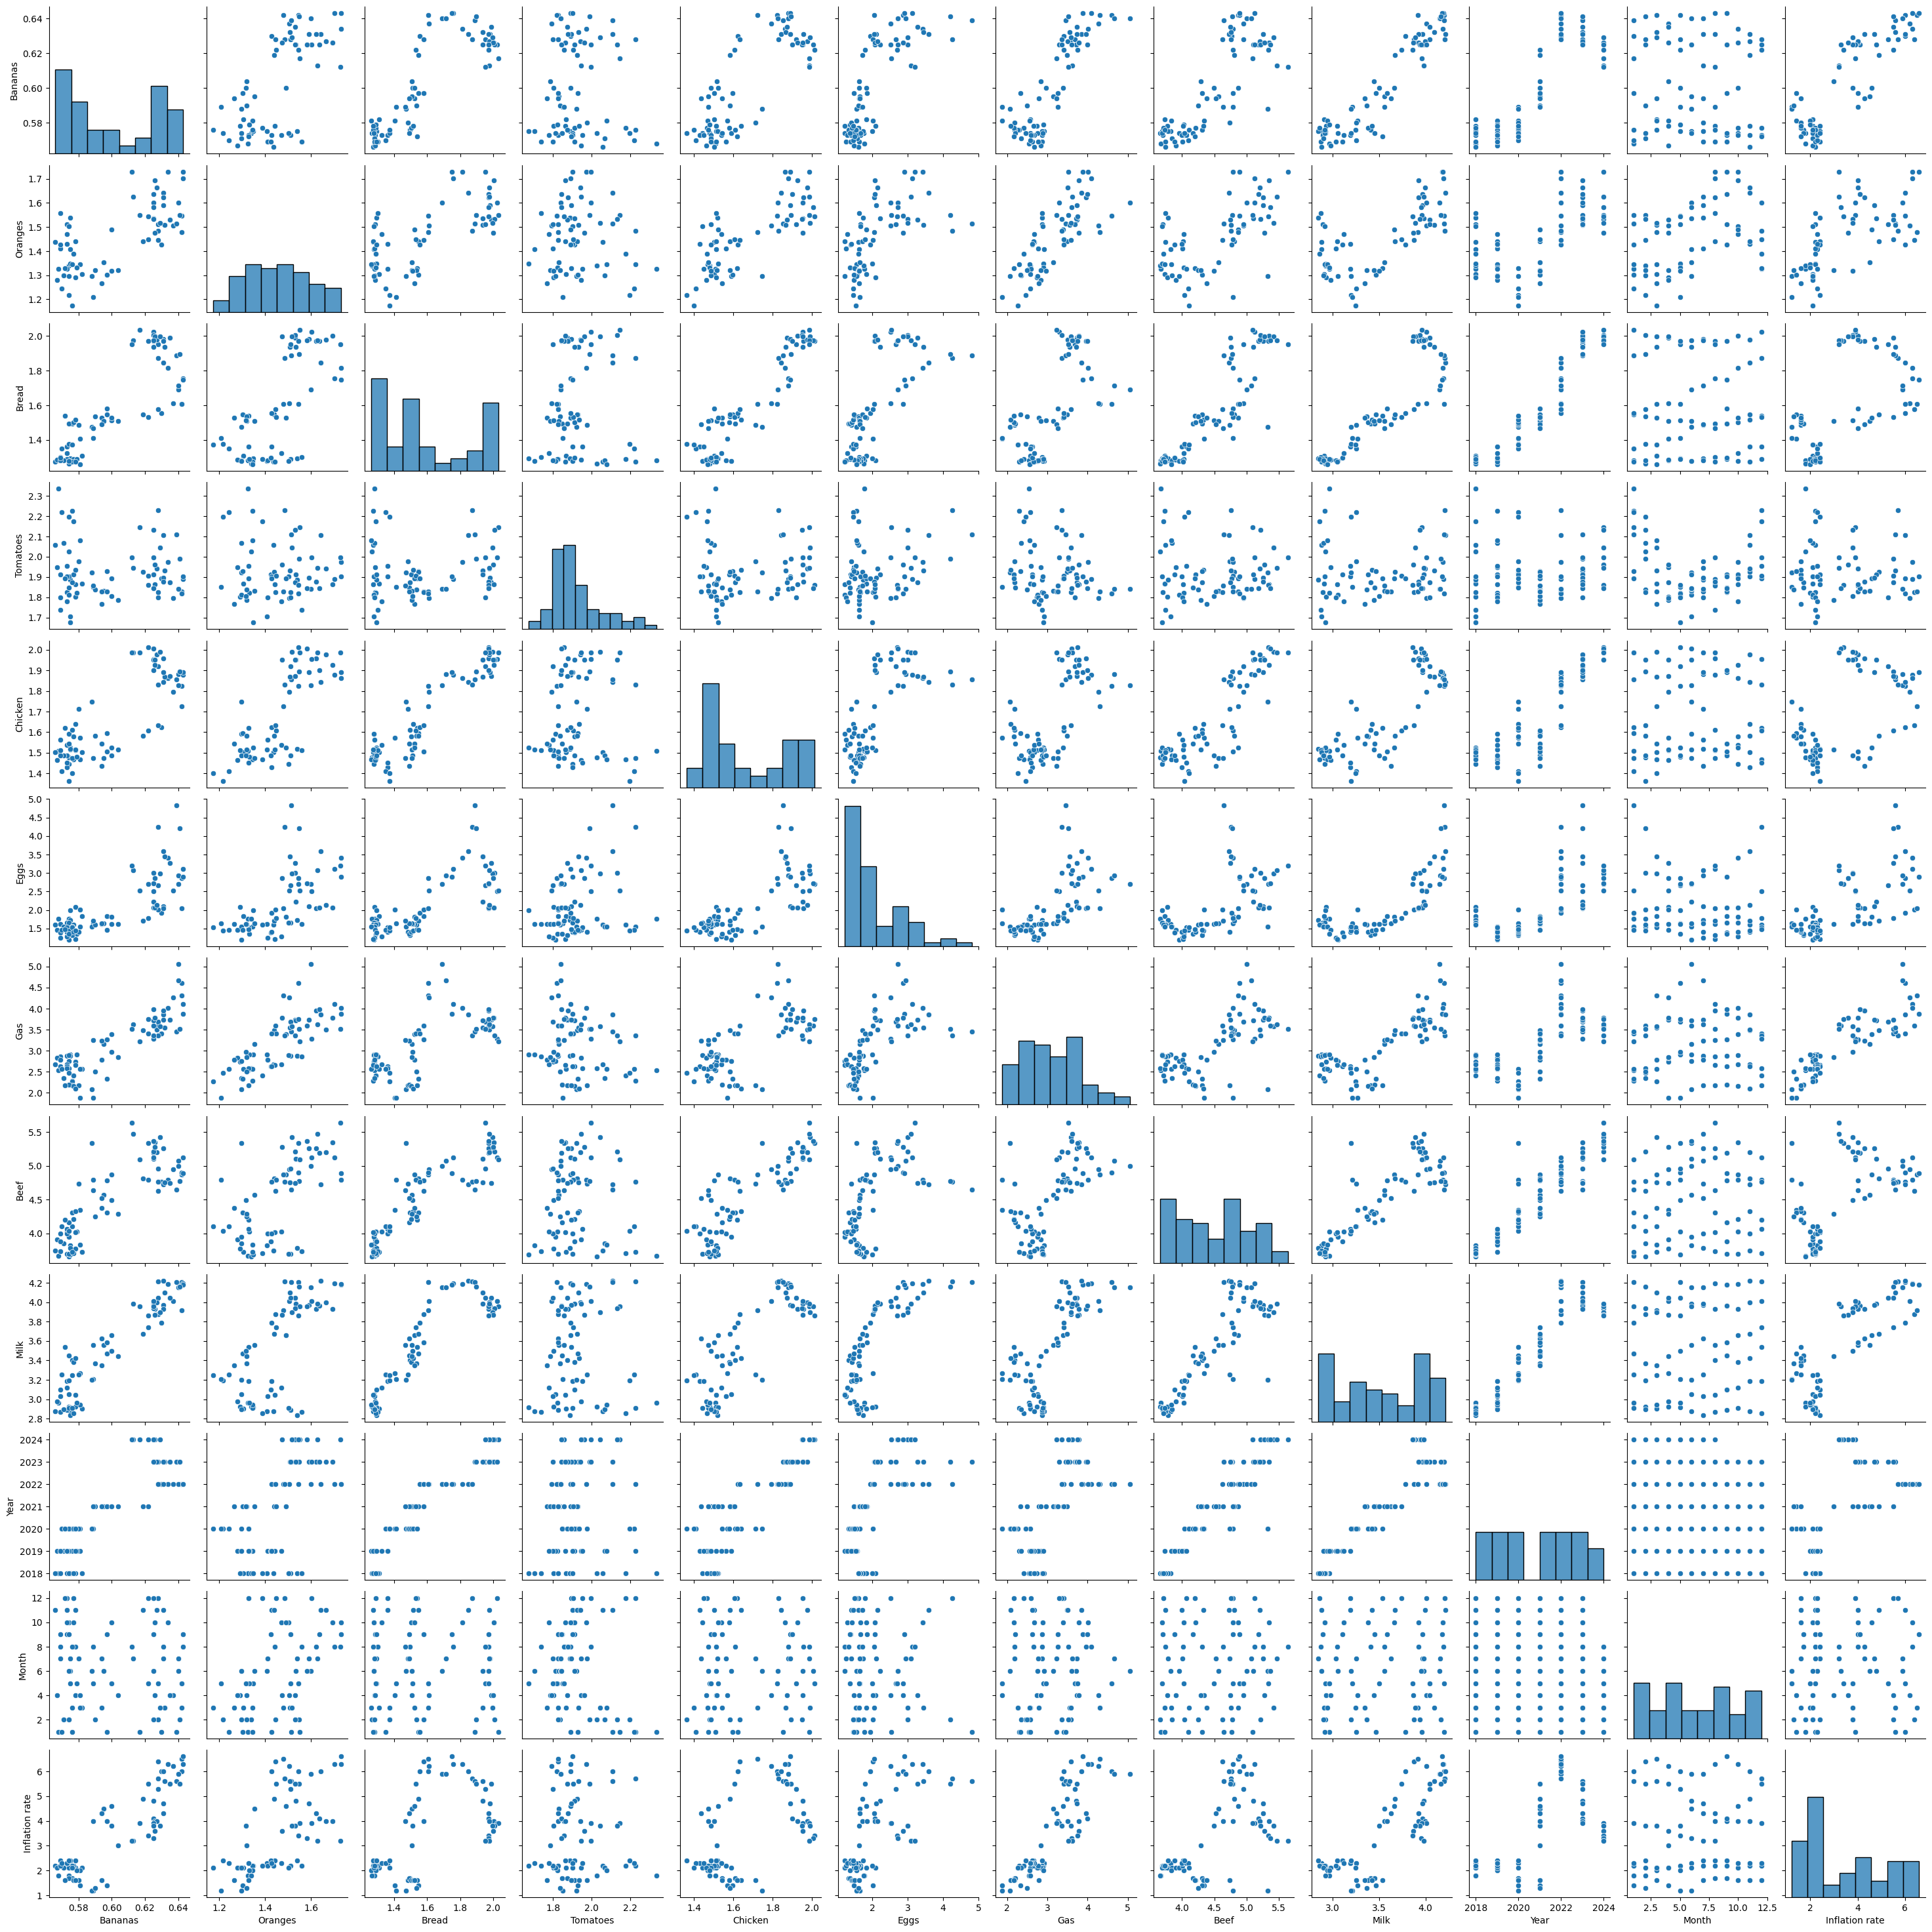

In [1076]:
combined_df = pd.merge(groceries_data, inflation_melted, on='Date', how='left')

# Create the pairplot for animal products and inflation rate
sns.pairplot(combined_df)
plt.show()
# combined_df

There is a somewhat strong linear relationship between inflation rates and grocery prices (unsurprisingly). I want to again make a heatmap of the correlations to see what is the strongest and weakest linear relationships between inflation and grocery item price.

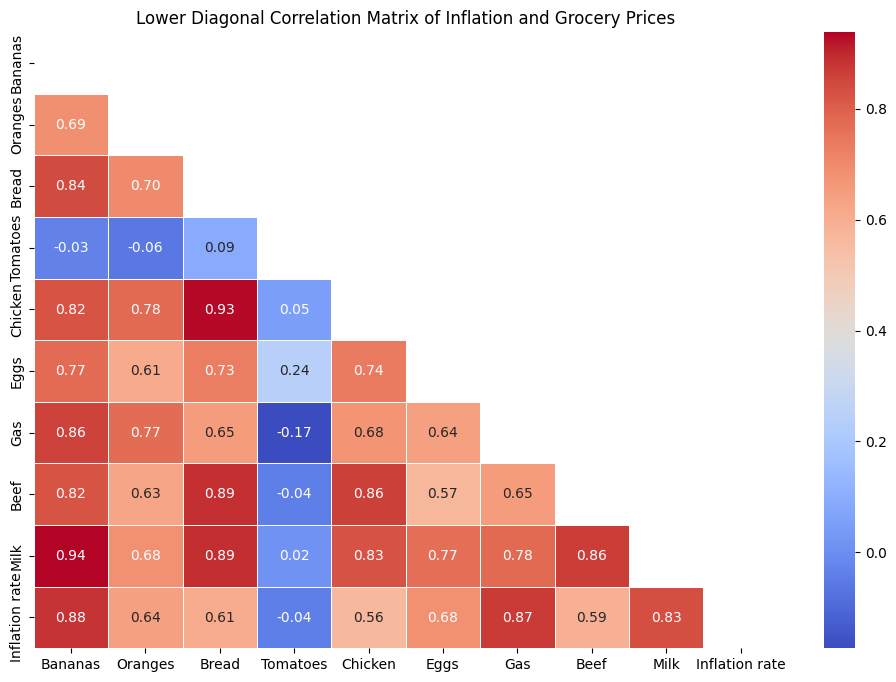

In [1077]:
# Selecting only numeric columns for correlation
numeric_prices = combined_df.drop(["Year", "Month"], axis=1).select_dtypes(include='number')

correlation_matrix_prices = numeric_prices.corr()

mask = np.triu(np.ones_like(correlation_matrix_prices, dtype=bool))

# Create the heatmap with the mask
plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix_prices, 
    mask=mask,  # Apply the mask to the upper triangle
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f", 
    linewidths=.5
)
plt.title("Lower Diagonal Correlation Matrix of Inflation and Grocery Prices")
plt.show()

In terms of strength of positive linear correlation with inflation, greatest is bananas, then gas, milk, eggs, oranges, bread, beef, and chicken (all corr > 0.5). Tomato prices don't appear to have a linear relationship with inflation. Gas is also positively correlated with all other items (except these weird tomatoes again).

### Conclusions of section 2
There may be non-linear relationships between pathogen isolate count, but there is a linear relationship between inflation rates and the price of all items. I plan to use PCA, using pathogens, gas, and inflation, to predict price. I assume that items not strongly correlated with gas and inflation will not be well-predicted. For example, it is unlikely that PCA will do well explaining the variation in tomato prices. Chicken might not be very good either (weakest association with inflation after tomatoes) </br>

##### Some assumptions and potential biases: </br>
1. Since inflation and gas are also linearly correlated, it may not be reasonable to use both gas prices and inflation rates to predict something since one depends on the other. The only reason I am going to do this is because gas prices are not solely determined by inflation rates. It is largely determined by supply and demand, geopolitical factors, and various supply chain factors.
2. "Inflation rate" is the "Consumer Price Index for All Urban Consumers (CPI-U)" according to the BLS. Title: "All items less food and energy in U.S. city average, all urban consumers, not seasonally adjusted". 

Let's look one last time at the data we are working with. We have all dataframes with actual DateTimes as the indices, and all data is restricted to 2018 to 2024, inclusive.

In [1078]:
inflation_melted = inflation_melted.drop(["Month", "Year"], axis=1)
display(groceries_data.head(), cdc_outbreaks.head(), inflation_melted.head())

,Bananas,Oranges,Bread,Tomatoes,Chicken,Eggs,Gas,Beef,Milk
Date,,,,,,,,,
2018-01-01,0.568,1.326,1.281,2.336,1.509,1.769,2.539,3.668,2.961
2018-02-01,0.574,1.339,1.265,2.026,1.478,1.755,2.575,3.659,2.923
2018-03-01,0.582,1.305,1.309,1.868,1.502,1.831,2.572,3.728,2.903
2018-04-01,0.578,1.291,1.281,1.802,1.511,2.081,2.737,3.775,2.924
2018-05-01,0.575,1.348,1.293,1.675,1.523,1.987,2.907,3.688,2.919


,State,Source,Pathogen,Serotype/Species,Number of isolates,Outbreak associated isolates,New multistate outbreaks,New multistate outbreaks - US,% Isolates with clinically important antimicrobial resistance,Number of sequenced isolates analyzed by NARMS
Date,,,,,,,,,,
2024-01-01,AK,Stool,Campylobacter,jejuni,1,NaN,NaN,NaN,NaN,NaN
2024-01-01,AL,Stool,Campylobacter,coli,1,NaN,NaN,NaN,NaN,NaN
2024-01-01,AL,Stool,Campylobacter,jejuni,2,NaN,NaN,NaN,NaN,NaN
2024-01-01,AR,Stool,Campylobacter,jejuni,1,NaN,NaN,NaN,NaN,NaN
2024-01-01,CA,Stool,Campylobacter,jejuni,1,NaN,NaN,NaN,NaN,NaN


,Inflation rate
Date,
2018-01-01,1.8
2019-01-01,2.2
2020-01-01,2.3
2021-01-01,1.4
2022-01-01,6.0


## Section 3: Prediction

### Setting up for PCA
I am going to start by combining all the data into one dataframe so that all of the regressors are in one dataframe. I won't be using the prices of other items to predict the prices of other items. First, I'll get rid of columns I dont think will be useful or that have a lot of NaN values. Then, I will join the 3 dataframes on Date, which should now all be DatetTime objects.

I am going to group by the month/year, and pathogen to get a good amount of granularity without overdoing it (I am not going to look at individual serotypes), then sum the number of occurences of each of those. I have also decided to only look at Salmonella to hopefully reduce the amount of noise in the model. I also know that Salmonella affects almost all items on this list, and it has the most occurences in the dataset. </br>


In [1079]:
cdc_outbreaks = cdc_outbreaks.drop(["Outbreak associated isolates", "New multistate outbreaks - US", "New multistate outbreaks", "% Isolates with clinically important antimicrobial resistance", "Number of sequenced isolates analyzed by NARMS"], axis=1).dropna()
# cdc_outbreaks = cdc_outbreaks[cdc_outbreaks["Pathogen"] == "Salmonella"]
cdc_outbreaks = cdc_outbreaks.groupby(["Date", "Pathogen", "Serotype/Species"]).sum("Number of isolates")

# I will just look at the number of isolates for a given pathogen on a given date (month & year combo)
cdc_outbreaks.head(20)

Number of isolates
Date       Pathogen      Serotype/Species                                  
2018-01-01 Campylobacter coli                                            24
                         fetus                                            1
                         jejuni                                         242
                         lari                                             4
                         upsaliensis                                      5
           Salmonella    Aberdeen                                         4
                         Adelaide                                         8
                         Agbeni                                          11
                         Ago                                              1
                         Agona                                           34
                         Altona                                           4
                         Anatum                                          12
                         Anatum, Newington, Minneapolis                  14
                         Apapa                                            1
                         Arechavaleta                                     3
                         Baildon                                          6
                         Bareilly                                        18
                         Berta                                           18
                         Blockley                                         4
                         Bovismorbificans                                 7

All the data merged, then seperate into regressors and values to predict (prices of each item).

In [1080]:
all_data_df = pd.merge(groceries_data, cdc_outbreaks, on="Date", how="inner")
all_data_df = all_data_df.merge(inflation_melted, on="Date", how="inner")
all_data_df

,Bananas,Oranges,Bread,Tomatoes,Chicken,Eggs,Gas,Beef,Milk,Number of isolates,Inflation rate
Date,,,,,,,,,,,
2018-01-01,0.568,1.326,1.281,2.336,1.509,1.769,2.539,3.668,2.961,24,1.8
2018-01-01,0.568,1.326,1.281,2.336,1.509,1.769,2.539,3.668,2.961,1,1.8
2018-01-01,0.568,1.326,1.281,2.336,1.509,1.769,2.539,3.668,2.961,242,1.8
2018-01-01,0.568,1.326,1.281,2.336,1.509,1.769,2.539,3.668,2.961,4,1.8
2018-01-01,0.568,1.326,1.281,2.336,1.509,1.769,2.539,3.668,2.961,5,1.8
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,0.612,1.728,1.951,1.996,1.988,3.204,3.521,5.638,NaN,1,3.2
2024-08-01,0.612,1.728,1.951,1.996,1.988,3.204,3.521,5.638,NaN,10,3.2
2024-08-01,0.612,1.728,1.951,1.996,1.988,3.204,3.521,5.638,NaN,32,3.2


In [1081]:
regressors = all_data_df[["Gas", "Number of isolates", "Inflation rate"]].dropna()

# Fill NaN values with the mean of each column for the prices, because this dataset is so limited (to only 80 rows)
actual_prices = all_data_df[["Bananas", "Oranges", "Bread", "Tomatoes", "Chicken", "Eggs", "Beef", "Milk"]].fillna(all_data_df[["Bananas", "Oranges", "Bread", "Tomatoes", "Chicken", "Eggs", "Beef", "Milk"]].mean())

display(regressors.head(), actual_prices.head())

,Gas,Number of isolates,Inflation rate
Date,,,
2018-01-01,2.539,24,1.8
2018-01-01,2.539,1,1.8
2018-01-01,2.539,242,1.8
2018-01-01,2.539,4,1.8
2018-01-01,2.539,5,1.8


,Bananas,Oranges,Bread,Tomatoes,Chicken,Eggs,Beef,Milk
Date,,,,,,,,
2018-01-01,0.568,1.326,1.281,2.336,1.509,1.769,3.668,2.961
2018-01-01,0.568,1.326,1.281,2.336,1.509,1.769,3.668,2.961
2018-01-01,0.568,1.326,1.281,2.336,1.509,1.769,3.668,2.961
2018-01-01,0.568,1.326,1.281,2.336,1.509,1.769,3.668,2.961
2018-01-01,0.568,1.326,1.281,2.336,1.509,1.769,3.668,2.961


In [1082]:
# Standardize the regressors (gas, isolates, inflation)
scaler = StandardScaler()
regressors_scaled = scaler.fit_transform(regressors)

# Apply PCA
pca = PCA(n_components=None)
pca_regressors = pca.fit_transform(regressors_scaled)

# Analyze explained variance
explained_variance = pca.explained_variance_ratio_

# Checking that this makes sense: should have a row for each row in the groceries data, and a col for each of the 3 regressors
len(pca_regressors)

13032

Now, I am going to use these trained regressors to do linear regression and see how well it predicts the prices.

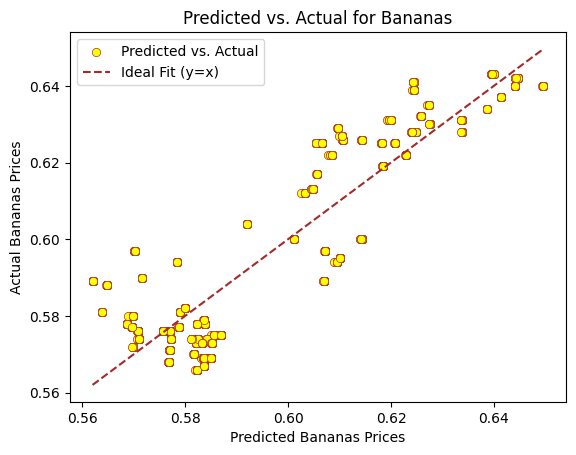

In [1083]:
# Let's just look at Bananas here to see how it predicts one item
X_train, X_test, y_train, y_test = train_test_split(
    pca_regressors, actual_prices['Bananas'], test_size=0.2, random_state=42
)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

r2 = r2_score(y_test, predictions)

sns.scatterplot(x=predictions, y=y_test, label="Predicted vs. Actual", c="yellow", edgecolor="brown")
min_val = min(y_test.min(), predictions.min())
max_val = max(y_test.max(), predictions.max())
plt.plot([min_val, max_val], [min_val, max_val], color="brown", linestyle="--", label="Ideal Fit (y=x)")
plt.xlabel("Predicted Bananas Prices")
plt.ylabel("Actual Bananas Prices")
plt.title("Predicted vs. Actual for Bananas")
plt.legend()
plt.show()


Component 1: 0.6269 explained variance, 0.6269 cumulative variance
Component 2: 0.3316 explained variance, 0.9585 cumulative variance
Component 3: 0.0415 explained variance, 1.0000 cumulative variance


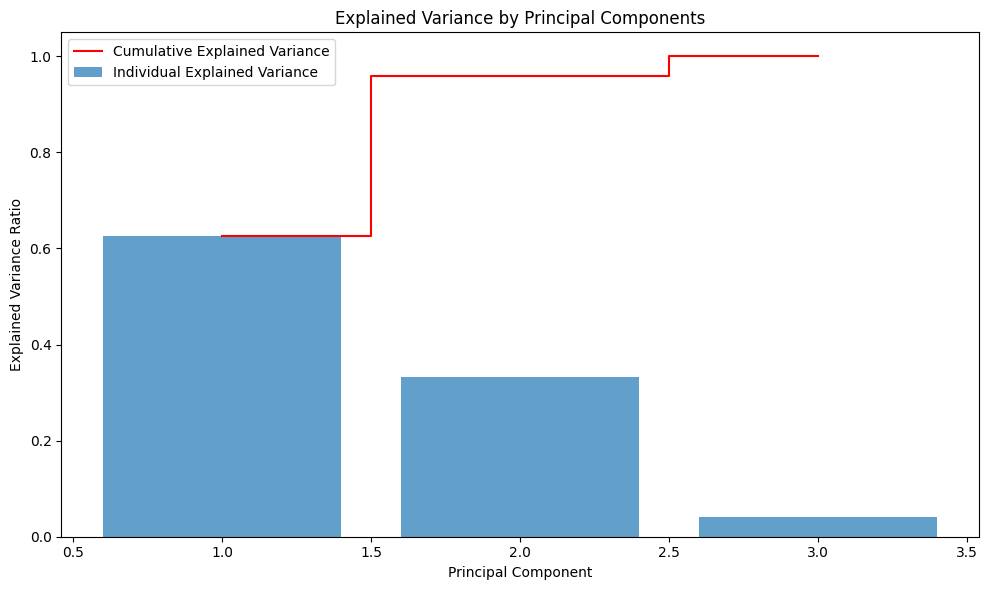

In [1084]:
# Analyze explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Display variance explained by each component
for i, (var, cum_var) in enumerate(zip(explained_variance, cumulative_variance), start=1):
    print(f"Component {i}: {var:.4f} explained variance, {cum_var:.4f} cumulative variance")

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, label="Individual Explained Variance")
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label="Cumulative Explained Variance", color='red')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance by Principal Components")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [1085]:
# Get the components / loadings
components = pca.components_

loadings_df = pd.DataFrame(components, columns=regressors.columns)
print("PCA Loadings:")
display(loadings_df)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("\nExplained variance by each component:")
for i, var in enumerate(explained_variance, start=1):
    print(f"Component {i}: {var:.4f} explained variance")

PCA Loadings:


,Gas,Number of isolates,Inflation rate
0,0.705373,0.079204,0.704397
1,-0.043608,0.996704,-0.068402
2,0.707493,-0.017532,-0.706502



Explained variance by each component:
Component 1: 0.6269 explained variance
Component 2: 0.3316 explained variance
Component 3: 0.0415 explained variance


#### Interpreting the PCA loadings and the three PCs
**First Component**:Reflects the combined effect of Gas and Inflation rate, both with strong positive loadings. This suggests, unsurprisingly, that gas and inflation vary together. </br>
**Second Component**: Primarily reflects the variation in Number of isolates, with almost no influence from "Gas" or "Inflation rate". This suggests that gas and inflation do not vary with number of isolates. </br>
**Third Component**: Reflects an inverse relationship between Gas and Inflation rate (both have strong, but opposite, loadings) of about 0.7. </br>

The first component explains about 62% of the variance, meaning that gas prices and inflation rates explain the most.


### Evaluating Predictions vs Actual Prices for Grocery Items  
Since it is not super useful to just know how much of the variance is explained by the model, I am going to evaluate how well the PCA-transformed data performs in predicting grocery item prices. By using the principal components as predictors in a linear regression model, I compare predicted prices with actual prices for various grocery items to assess the effectiveness of PCA in simplifying the data without losing critical information.

### Steps:  
1. **Initialize**  
   - Create a list to store actual and predicted prices for each grocery item (`all_comparisons`).  
   - Maintain a list to record model performance metrics such as Mean Squared Error (MSE) and R-squared (`model_performance`).  

2. **Iterate through each grocery item:**  
   - For each item, use PCA-transformed data as predictors and the item's price data as the response variable.

3. **Split the data:**  
   - Use `train_test_split` to divide the PCA-transformed data (`pca_regressors`) and the corresponding prices into training and testing sets (80/20 split).

4. **Train the regression model:**  
   - Fit a `LinearRegression` model using the training data to establish the relationship between PCA components and the grocery item's price.

5. **Make predictions:**  
   - Use the trained model to predict prices for the test data.  
   - Create a DataFrame to compare predicted and actual prices for each item, ensuring that indices align and any `NaN` values are removed.

6. **Evaluate the model:**  
   - Compute the MSE to measure the average squared difference between predicted and actual prices.  
   - Calculate R-squared to assess how well the model explains the variance in the actual prices.  
   - Append the comparison and performance metrics to their respective lists.

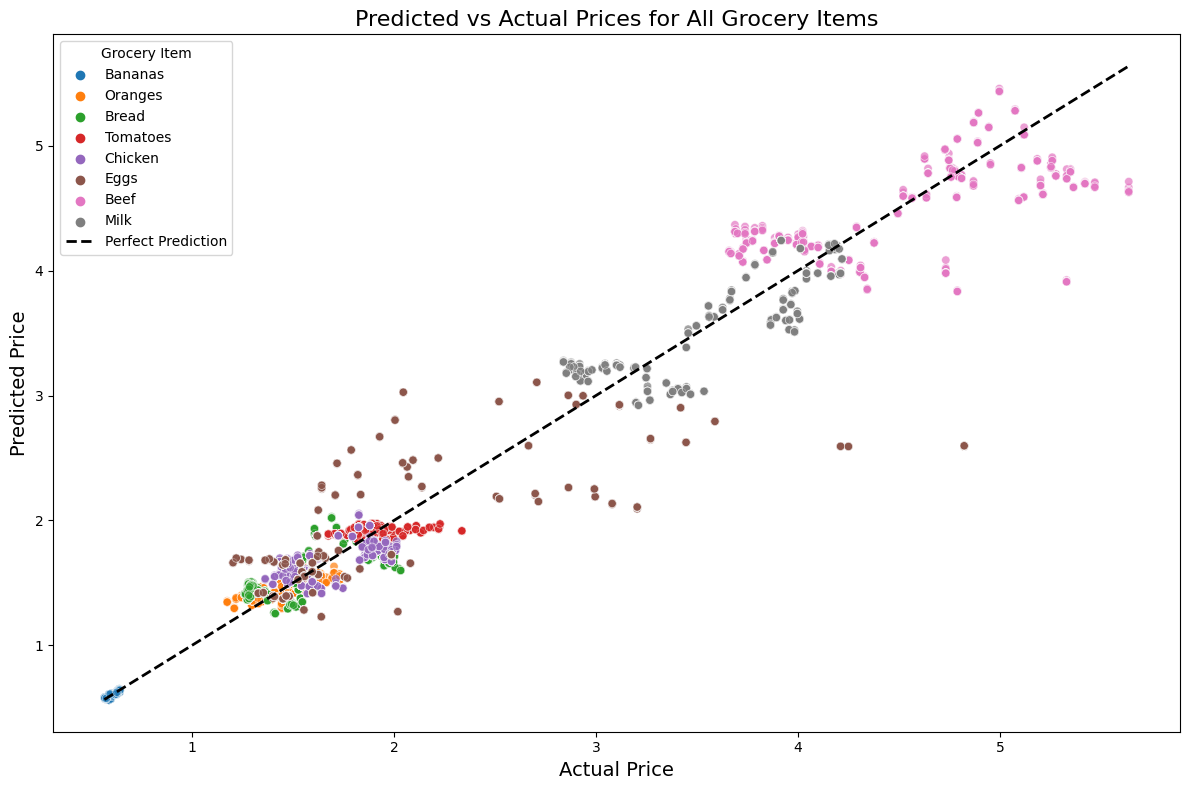

,Item,MSE,R-squared
0,Bananas,0.000131,0.804160
1,Oranges,0.008718,0.439252
2,Bread,0.037314,0.436638
3,Tomatoes,0.016472,0.083809
4,Chicken,0.020768,0.429848
5,Eggs,0.277489,0.479566
6,Beef,0.176920,0.436588
7,Milk,0.062834,0.696470


,Actual Price,Predicted Price,Item
0,0.643,0.639587,Bananas
1,0.582,0.580033,Bananas
2,0.574,0.571070,Bananas
3,0.578,0.583846,Bananas
4,0.573,0.582072,Bananas
...,...,...,...
20851,2.961,3.112879,Milk
20852,3.560,3.628636,Milk
20853,3.248,3.143127,Milk
20854,3.557,3.717247,Milk


In [1086]:
grocery_items = ['Bananas', 'Oranges', 'Bread', 'Tomatoes', 'Chicken', 'Eggs', 'Beef', 'Milk']

# Create a DataFrame to store actual and predicted prices for all items
all_comparisons = []
model_performance = []  

for item in grocery_items:
    X_train, X_test, y_train, y_test = train_test_split(pca_regressors, actual_prices[item], test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    # Ensure y_test is a pandas Series and reset its index
    y_test = pd.Series(y_test).reset_index(drop=True)
    predictions = pd.Series(predictions, name="Predicted Price")
    
    comparison = pd.DataFrame({
        "Actual Price": y_test,
        "Predicted Price": predictions
    }).dropna()
    
    mse = mean_squared_error(comparison["Actual Price"], comparison["Predicted Price"])
    r2 = r2_score(comparison["Actual Price"], comparison["Predicted Price"])
    
    # Add the grocery item to the comparison DataFrame
    comparison['Item'] = item
    all_comparisons.append(comparison)
    
    # Store the performance metrics
    model_performance.append({
        'Item': item,
        'MSE': mse,
        'R-squared': r2
    })

# Combine all comparisons into a single DataFrame
all_comparisons_df = pd.concat(all_comparisons, ignore_index=True)

# Create a DataFrame for model performance
performance_df = pd.DataFrame(model_performance)

plt.figure(figsize=(12, 8))
sns.scatterplot(data=all_comparisons_df, x="Actual Price", y="Predicted Price", hue="Item", alpha=0.7)

plt.plot([all_comparisons_df["Actual Price"].min(), all_comparisons_df["Actual Price"].max()],
         [all_comparisons_df["Actual Price"].min(), all_comparisons_df["Actual Price"].max()],
         'k--', linewidth=2, label="Perfect Prediction")

plt.title("Predicted vs Actual Prices for All Grocery Items", fontsize=16)
plt.xlabel("Actual Price", fontsize=14)
plt.ylabel("Predicted Price", fontsize=14)
plt.legend(title="Grocery Item")
plt.tight_layout()
plt.show()

display(performance_df, all_comparisons_df)

I attempted the above using just the first 2 PCs (delted the code because it wasn't very significant), and the only significant difference was that tomatoes' R-squared went from 0.08 to 0.01. It makes sense that none of the R-squared improved because if a component explains any of the variation in the data, it will improve the R-squared. Taking away a component will necessarily make the guesses worse. The way I am interpreting the decrease from 0.08 to 0.01 for tomatoes is that PC3 was explaining a decent amount of the variation. Maybe PCA is not the best model for explaining variation in tomato prices.

## Findings
- **Bananas and Milk:** These items have high R-squared values, indicating their prices are closely tied to gas prices, inflation, and outbreaks.
- **Oranges, Bread, Chicken, Eggs, and Beef:** These items are moderately predictable. Including additional explanatory variables might improve the model.
- **Tomatoes:** With a very low R-squared, key factors affecting tomato prices appear to be missing from the dataset.

##### Bananas
While bananas and milk are better predicted by this model, we see a cluster of blue dots at the lower end of the scatterplot, showing that banana prices are relatively stable. Bananas are in consistent demand year-round, regardless of the season. The strong connection to gas prices might stem from the U.S. importing bananas from South America, where the climate is ideal for growing them.

##### Milk
Milk is particularly intriguing. Its price varies significantly relative to other grocery items, yet the model explains **70% of this variation**. Determining which principal component contributes most to this explanation would be a valuable next step (done below this cell).

---

### Tomato Anomaly
We observed earlier that tomatoes have a slight negative correlation with some of the foodborne illnesses (about -0.3) AND we observed that tomatoes do not have a linear relationship with inflation. We can see on the predictions above that the PCA model predicts almost no increase in price, even though it does fluctuate slightly. We also did not see a linear relationship between tomato price and gas price. These three factors, respectively, mean that this model is a very bad model for tomatoes. I was looking into tomatoes to see why they don't correlate with inflation: </br>

**Imported Tomatoes:** The U.S. grows only about [40% of its tomatoes domestically](https://edis.ifas.ufl.edu/publication/FE1027), with the remaining 60% imported—mostly from Mexico and some from Canada.

**[Tomato Suspension Agreement:](https://www.ams.usda.gov/services/sci/fresh-products/tomato-suspension-agreement)**
This agreement between the U.S. Department of Commerce (USDOC) and Mexican tomato exporters was established in 1996 and last updated in 2019. Its key features include:
- Preventing Mexican tomatoes from being sold in the U.S. at unfairly low prices.
- Setting minimum reference prices to stabilize the market and protect domestic producers.

While the agreement likely increased overall tomato prices, it also reduces price fluctuation by stabilizing import prices. This might at least help explain why the price of tomatoes isn't largely determined by inflation and gas prices. However, it could also be completely irrelevant here!

In [1087]:
## Looking at milk to see which PCs contribute most 

# Train-test split for milk
X_train, X_test, y_train, y_test = train_test_split(pca_regressors, actual_prices['Milk'], test_size=0.2, random_state=42)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Get model coefficients
coefficients = model.coef_

# Create a DataFrame to associate coefficients with principal components
pc_contributions = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(coefficients))],
    'Coefficient': coefficients
})

pc_contributions

,Principal Component,Coefficient
0,PC1,0.271185
1,PC2,-0.022223
2,PC3,-0.170435


PC1's coefficient is about 0.3. Recalling that PC1 represents the positive strong relationship between gas and inflation, it might just be that milk prices are very sensitive to inflation, so this model is good for predicting fluctuations in milk prices.

#### Tomato Random Forest
What if the tomatoes just vary super specifically with the seasons. I want to see if I can just add the season as a predictor to see if it has a significant impact on the R^2. </br>
Note: originally I did PCA with the season column and it did get up to R^2 = 0.27, but I thought random forest might be interesting to try. So, I am doing random forest for just the tomatoes and I am adding a month column (numeric, so that it can be interpreted).

In [1088]:
# Reset index to access "Date" column
reg = regressors.reset_index()

# Group by "Date" and calculate the sum for numeric columns
reg_grouped = reg.groupby("Date").sum("Number of isolates").reset_index()

# Create a "Season" column based on the month
def assign_season(month):
    if month in [12, 1, 2]:
        return 1
    elif month in [3, 4, 5]:
        return 3
    elif month in [6, 7, 8]:
        return 4
    elif month in [9, 10, 11]:
        return 2

reg_grouped["Season"] = reg_grouped["Date"].dt.month.apply(assign_season)

# Set "Date" as the index
reg_grouped = reg_grouped.set_index("Date")

reg_grouped.head()


,Gas,Number of isolates,Inflation rate,Season
Date,,,,
2018-01-01,418.935,2810,297.0,1
2018-02-01,437.750,2581,306.0,1
2018-03-01,457.816,2884,373.8,3
2018-04-01,489.923,3395,375.9,3
2018-05-01,584.307,4577,442.2,3


Random Forest MSE: 0.0139
Random Forest R-squared: 0.4532


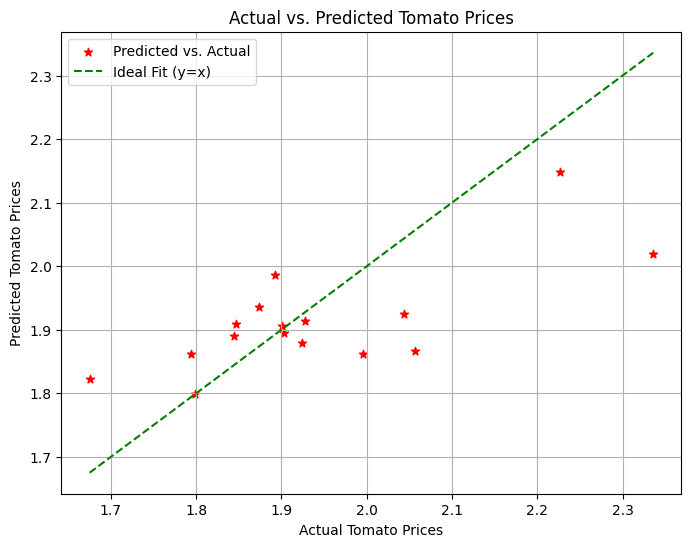

In [1089]:
y = groceries_data['Tomatoes'].dropna()

# Align `X` with the index of `y`
X = reg_grouped.loc[y.index]

X_train_tomatoes, X_test_tomatoes, y_train_tomatoes, y_test_tomatoes = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_tomatoes, y_train_tomatoes)

rf_predictions = rf_model.predict(X_test_tomatoes)

# Evaluate model performance
rf_mse = mean_squared_error(y_test_tomatoes, rf_predictions)
rf_r2 = r2_score(y_test_tomatoes, rf_predictions)

print(f"Random Forest MSE: {rf_mse:.4f}")
print(f"Random Forest R-squared: {rf_r2:.4f}")

# Plot actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test_tomatoes, rf_predictions, label="Predicted vs. Actual", marker='*', c="red")

min_val = min(y_test_tomatoes.min(), rf_predictions.min())
max_val = max(y_test_tomatoes.max(), rf_predictions.max())
plt.plot([min_val, max_val], [min_val, max_val], color="green", linestyle="--", label="Ideal Fit (y=x)")

plt.xlabel("Actual Tomato Prices")
plt.ylabel("Predicted Tomato Prices")
plt.title("Actual vs. Predicted Tomato Prices")
plt.legend()
plt.grid(True)
plt.show()

The random forest does a much better job than PCA at predicting price (from R-squared of 0.08 up to 0.45). Rather, it does a much better job explaining the variation in the price as it relates to the predictors. This is probably because the fluctuations in tomato prices are very subtle and probably nonlinear. PCA does a good job when things have linear relationships. PCA also reduces dimensionality because this is how it is able to generate the 3 principal components. </br>
Does the random forest just do better for all items?

In [1090]:
grocery_items = groceries_data.drop('Gas', axis=1).columns  # Assuming columns represent different grocery items

# Initialize lists to store performance metrics for each item
mse_list = []
r2_list = []

for item in grocery_items:
    y = groceries_data[item].dropna()

    X = reg_grouped.loc[y.index]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    rf_predictions = rf_model.predict(X_test)

    rf_mse = mean_squared_error(y_test, rf_predictions)
    rf_r2 = r2_score(y_test, rf_predictions)

    mse_list.append(rf_mse)
    r2_list.append(rf_r2)

# Create a DataFrame to display the results
performance_df_forest = pd.DataFrame({
    'Grocery Item': grocery_items,
    'MSE': mse_list,
    'R-squared': r2_list
})

# Display the DataFrames to compare (forest regression vs PCA-trained regression)
display(performance_df_forest, performance_df)

,Grocery Item,MSE,R-squared
0,Bananas,0.000113,0.794479
1,Oranges,0.012046,-0.044330
2,Bread,0.018407,0.687915
3,Tomatoes,0.013873,0.453233
4,Chicken,0.005823,0.773696
5,Eggs,0.345429,-3.174718
6,Beef,0.080345,0.735443
7,Milk,0.036295,0.761405


,Item,MSE,R-squared
0,Bananas,0.000131,0.804160
1,Oranges,0.008718,0.439252
2,Bread,0.037314,0.436638
3,Tomatoes,0.016472,0.083809
4,Chicken,0.020768,0.429848
5,Eggs,0.277489,0.479566
6,Beef,0.176920,0.436588
7,Milk,0.062834,0.696470


This model does better for all items except for eggs and oranges. In fact, it is so bad at predicting the price of both that the R-squared is negative, meaning a straight line would predict it better than the random forest regressor. One guess as to why these specific items can't be reliably predicted is because this random forest includes the season as a factor. Maybe it is overfitting to the season. It is also possible that we just do not have enough data to reliably predict items for this type of model, where every factor is weighted heavily (as opposed to PCA where some smoothing is done to reduce dimensionality).

#### Is this model useful?
PCA is more interpretable compared to the random forest, so it is more of a useful model, even if the R-squared values are not as good. It explains how much gas and inflation contribute to explaining the variation in grocery prices. We also saw how much variation foodborne illnesses explains (about 30%). In doing this project, I researched certain grocery items, and realized it would have been a good idea to incorporate importation in some way. Tomatoes, bananas, and oranges are often imported, which likely affects their price. With only three regressors, PCA can only do so well, but the model is still useful.